# The required packages.

In [213]:
import import_ipynb
import copy
import time
import random
import pandas as pd
import numpy as np
from numpy import genfromtxt
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from mpl_toolkits.mplot3d import Axes3D

# The PartitionNode Class.
It maintains the meta infos of a partition.
It also provides support functions related to split and query overlap checking.

In [214]:
class PartitionNode:
    '''
    A partition node, including both the internal and leaf nodes in the partition tree
    '''
    def __init__(self, num_dims = 0, boundary = [], nid = None, pid = None, is_irregular_shape_parent = False,
                 is_irregular_shape = False, num_children = 0, children_ids = [], is_leaf = True, node_size = 0):
        
        # print("Initialize PartitionTree Root: num_dims",num_dims,"boundary:",boundary,"children_ids:",children_ids)
        self.num_dims = num_dims # number of dimensions
        # the domain, [l1,l2,..,ln, u1,u2,..,un,], for irregular shape partition, one need to exempt its siblings
        self.boundary = boundary # I think the lower side should be inclusive and the upper side should be exclusive?
        self.nid = nid # node id
        self.pid = pid # parent id
        self.is_irregular_shape_parent = is_irregular_shape_parent # whether the [last] child is an irregular shape partition
        self.is_irregular_shape = is_irregular_shape # an irregular shape partition cannot be further split, and it must be a leaf node
        self.num_children = num_children # number of children, should be 0, 2, or 3
        self.children_ids = children_ids # if it's the irregular shape parent, then the last child should be the irregular partition
        self.is_leaf = is_leaf
        self.node_size = node_size # number of records in this partition
        
        self.dataset = None # only used in partition algorithms, tempoary, should consist records that within this partition
        self.queryset = None # only used in partition algorithms, tempoary, should consist queries that overlap this partition
        
    def is_overlap(self, query):
        '''
        query is in plain form, i.e., [l1,l2,...,ln, u1,u2,...,un]
        !query dimension should match the partition dimensions! i.e., all projected or all not projected
        return 0 if no overlap
        return 1 if overlap
        return 2 if inside
        '''
        if len(query) != 2 * self.num_dims:
            return -1 # error
        
        overlap_flag = True
        inside_flag = True
        
        for i in range(self.num_dims):
            if query[i] >= self.boundary[self.num_dims + i] or query[self.num_dims + i] <= self.boundary[i]:
                overlap_flag = False
                inside_flag = False
                return 0
            elif query[i] < self.boundary[i] or query[self.num_dims + i] > self.boundary[self.num_dims + i]:
                inside_flag = False
                
        if inside_flag:
            return 2
        elif overlap_flag:
            return 1
        else:
            return 0
    
    def is_overlap_np(self, query):
        '''
        the numpy version of the is_overlap function
        the query here and boundary class attribute should in the form of numpy array
        '''
        if all((boundary[0:self.num_dims] > query[self.num_dims:]) | (boundary[self.num_dims:] <= query[0:self.num_dims])):
            return 0 # no overlap
        elif all((boundary[0:self.num_dims] >= query[0:self.num_dims]) & (boundary[self.num_dims:] <= query[self.num_dims:])):
            return 2 # inside
        else:
            return 1 # overlap
    
    def get_candidate_cuts(self, extended = False):
        '''
        get the candidate cut positions
        if extended is set to True, also add medians from all dimensions
        '''
        candidate_cut_pos = []
        for query in self.queryset:
            for dim in range(self.num_dims):
                # check if the cut position is inside the partition, as the queryset are queries overlap this partition
                if query[dim] >= self.boundary[dim] and query[dim] <= self.boundary[self.num_dims+dim]:
                    candidate_cut_pos.append((dim, query[dim]))
                if query[self.num_dims+dim] >= self.boundary[dim] and query[self.num_dims+dim] <= self.boundary[self.num_dims+dim]:
                    candidate_cut_pos.append((dim, query[self.num_dims+dim]))
        
        if extended:
            for dim in range(self.num_dims):
                split_value = np.median(self.dataset[:,dim])
                candidate_cut_pos.append((dim, split_value))
        
        return candidate_cut_pos
    
    def if_split(self, split_dim, split_value, data_threshold, test = False): # rename: if_split_get_gain
        '''
        return the skip gain and children partition size if split a node from a given split dimension and split value
        '''
        #print("current_node.nid:", current_node.nid)
        #print("current_node.is_leaf:", current_node.is_leaf)
        #print("current_node.dataset is None:", current_node.dataset is None)
        sub_dataset1_size = np.count_nonzero(self.dataset[:,split_dim] < split_value) # process time: 0.007
        sub_dataset2_size = self.node_size - sub_dataset1_size

        if sub_dataset1_size < data_threshold or sub_dataset2_size < data_threshold:
            return -1, sub_dataset1_size, sub_dataset2_size
        
        left_part, right_part, mid_part = self.split_queryset(split_dim, split_value)
        num_overlap_child1 = len(left_part) + len(mid_part)
        num_overlap_child2 = len(right_part) + len(mid_part)
        
        if test:
            print("num left part:",len(left_part), "num right part:",len(right_part), "num mid part:",len(mid_part))
            print("left part:", left_part, "right part:", right_part, "mid part:",mid_part)
        
        # temp_child_node1, temp_child_node2 = self.__if_split_get_child(split_dim, split_value)
        skip_gain = len(self.queryset)*self.node_size - num_overlap_child1*sub_dataset1_size - num_overlap_child2*sub_dataset2_size
        return skip_gain, sub_dataset1_size, sub_dataset2_size
    
    def if_bounding_split(self, data_threshold, approximate = False):
        max_bound = self.__max_bound(self.queryset)
        bound_size = self.query_result_size(max_bound, approximate)
        if bound_size is None or bound_size < data_threshold: 
            return False, None
        remaining_size = self.node_size - bound_size
        if remaining_size < data_threshold:
            return False, None
        cost_before_split = len(self.queryset) * self.node_size
        cost_bound_split = len(self.queryset) * bound_size
        skip_gain = cost_before_split - cost_bound_split
        return True, skip_gain
    
    def if_dual_bounding_split(self, split_dim, split_value, data_threshold, approximate = False):
        '''
        check whether it's available to perform dual bounding split
        '''
        # split queriese first
        left_part, right_part, mid_part = self.split_queryset(split_dim, split_value)
        max_bound_left = self.__max_bound(left_part)
        max_bound_right = self.__max_bound(right_part)
        
        # Should we only consider the case when left and right cannot be further split? i.e., [b,2b)
        # this check logic is given in the PartitionAlgorithm, not here, as the split action should be general
        naive_left_size = np.count_nonzero(self.dataset[:,split_dim] < split_value)
        naive_right_size = self.node_size - naive_left_size
        
        # get (irregular-shape) sub-partition size
        left_size = self.query_result_size(max_bound_left, approximate)
        if left_size is None: # there is no query within the left 
            left_size = naive_left_size # use the whole left part as its size
        if left_size < data_threshold:
            return False, None
        right_size = self.query_result_size(max_bound_right, approximate)
        if right_size is None: # there is no query within the right
            right_size = naive_right_size # use the whole right part as its size
        if right_size < data_threshold:
            return False, None
        remaining_size = self.node_size - left_size - right_size
        if remaining_size < data_threshold:
            return False, None
        
        # check cost
        cost_before_split = len(self.queryset) * self.node_size
        cost_dual_split = len(left_part) * left_size + len(right_part) * right_size + len(mid_part) * remaining_size
        for query in mid_part:
            # if it overlap left bounding box
            if max_bound_left is None or self.__is_overlap(max_bound_left, query) > 0:
                cost_dual_split += left_size
            # if it overlap right bounding box
            if max_bound_right is None or self.__is_overlap(max_bound_right, query) > 0:
                cost_dual_split += right_size
        skip_gain = cost_before_split - cost_dual_split
        return True, skip_gain
        
    
    def split_queryset(self, split_dim, split_value):
        '''
        split the queryset into 3 parts:
        the left part, the right part, and those cross the split value
        '''
        if self.queryset is not None:
            left_part = []
            right_part = []
            mid_part = []
            for query in self.queryset:
                if query[split_dim] >= split_value:
                    right_part.append(query)
                elif query[self.num_dims + split_dim] <= split_value:
                    left_part.append(query)
                elif query[split_dim] < split_value and query[self.num_dims + split_dim] > split_value:
                    mid_part.append(query)
            return left_part, right_part, mid_part
        
    def query_result_size(self, query, approximate = False):
        '''
        get the query result's size on this node
        the approximate parameter is set to True, the use even distribution to approximate
        '''
        if query is None:
            return None
        
        result_size = 0
        if approximate:
            query_volume = 1
            volume = 1
            for d in range(self.num_dims):
                query_volume *= query[self.num_dims + d] - query[d]
                volume *= self.boundary[self.num_dims + d] - self.boundary[d]

            result_size = int(query_volume / volume * self.node_size)
        else:
            constraints = []
            for d in range(self.num_dims):
                constraint_L = dataset[:,d] >= query[d]
                constraint_U = dataset[:,d] <= query[self.num_dims + d]
                constraints.append(constraint_L)
                constraints.append(constraint_U)
            constraint = np.all(constraints, axis=0)
            result_size = np.count_nonzero(constraint)
        return result_size
    
    # = = = = = internal functions = = = = =
    
    def __is_overlap(self, boundary, query):
        '''
        the difference between this function and the public is_overlap function lies in the boundary parameter
        '''
        if len(query) != 2 * self.num_dims:
            return -1 # error
        
        overlap_flag = True
        inside_flag = True
        
        for i in range(self.num_dims):
            if query[i] >= boundary[self.num_dims + i] or query[self.num_dims + i] <= boundary[i]:
                overlap_flag = False
                inside_flag = False
                return 0
            elif query[i] < boundary[i] or query[self.num_dims + i] > boundary[self.num_dims + i]:
                inside_flag = False
                
        if inside_flag:
            return 2
        elif overlap_flag:
            return 1
        else:
            return 0
    
    def __max_bound(self, queryset):
        '''
        bound the queries by their maximum bounding rectangle
        then constraint the MBR by the node's boundary!
        '''
        if len(queryset) == 0:
            return None
        #if len(queryset) == 1:
        #    pass, I don't think there will be shape issue here
        
        max_bound_L = np.amin(np.array(queryset)[:,0:self.num_dims],axis=0).tolist()
        # bound the lower side with the boundary's lower side
        max_bound_L = np.amax(np.array([max_bound_L, self.boundary[0:self.num_dims]]),axis=0).tolist()
        
        max_bound_U = np.amax(np.array(queryset)[:,self.num_dims:],axis=0).tolist()
        # bound the upper side with the boundary's upper side
        max_bound_U = np.amin(np.array([max_bound_U, self.boundary[self.num_dims:]]),axis=0).tolist()
        
        max_bound = max_bound_L + max_bound_U # concat
        return max_bound
    
    def __if_split_get_child(self, split_dim, split_value): # should I rename this to if_split_get_child
        '''
        return 2 child nodes if a split take place on given dimension with given value
        This function is only used to simplify the skip calculation process, it does not really split the node
        '''
        boundary1 = self.boundary.copy()
        boundary1[split_dim + self.num_dims] = split_value
        boundary2 = self.boundary.copy()
        boundary2[split_dim] = split_value
        child_node1 = PartitionNode(self.num_dims, boundary1)
        child_node2 = PartitionNode(self.num_dims, boundary2)
        return child_node1, child_node2

# The PartitionTree Class.
It maintain the structure of the whole partition process, including intermediate nodes and the final leaf partitions.
It also provides functions to maintain, serialize, and query the tree.

In [215]:
 class PartitionTree:
        '''
        The data structure that represent the partition layout, which also maintain the parent, children relation info
        Designed to provide efficient online query and serialized ability
        
        The node data structure could be checked from the PartitionNode class
        
        '''   
        def __init__(self, num_dims = 0, boundary = []):
            
            # the node id of root should be 0, its pid should be -1
            # note this initialization does not need dataset and does not set node size!

            self.pt_root = PartitionNode(num_dims, boundary, nid = 0, pid = -1, is_irregular_shape_parent = False, 
                                         is_irregular_shape = False, num_children = 0, children_ids = [], is_leaf = True, node_size = 0)
            self.nid_node_dict = {0: self.pt_root} # node id to node dictionary
            self.node_count = 1 # the root node
            
        
        # = = = = = public functions (API) = = = = =
        
        def save_tree(self, path):
            node_list = self.__generate_node_list(self.pt_root) # do we really need this step?
            serialized_node_list = self.__serialize(node_list)
            np.savetxt(path, serialized_node_list, delimiter=',')
            return serialized_node_list
            
        def load_tree(self, path):
            serialized_node_list = genfromtxt(path, delimiter=',')
            self.__build_tree_from_serialized_node_list(serialized_node_list)
        
        def query_single(self, query):
            '''
            query is in plain form, i.e., [l1,l2,...,ln, u1,u2,...,un]
            return the overlapped leaf partitions ids!
            '''
            partition_ids = self.__find_overlapped_partition(self.pt_root, query)
            return partition_ids
        
        def query_batch(self, queries):
            '''
            to be implemented
            '''
            pass
        
        def evaluate_query_cost(self, queries):
            '''
            get the logical IOs of the queris
            '''
            cost = 0
            case = 0
            total_overlap_ids = {}
            for query in queries:
                overlapped_leaf_ids = self.query_single(query)
                total_overlap_ids[case] = overlapped_leaf_ids
                case += 1
                for nid in overlapped_leaf_ids:
                    cost += self.nid_node_dict[nid].node_size
            print("Total logical IOs:", cost)
            print("Average logical IOs:", cost // len(queries))
            
            for case, ids in total_overlap_ids.items():
                print("query",case, ids)
            
            return cost
        
        def add_node(self, parent_id, child_node):
            child_node.nid = self.node_count
            self.node_count += 1
            
            child_node.pid = parent_id
            self.nid_node_dict[child_node.nid] = child_node
            
            self.nid_node_dict[parent_id].children_ids.append(child_node.nid)
            self.nid_node_dict[parent_id].num_children += 1
            self.nid_node_dict[parent_id].is_leaf = False
        
        
        def apply_split(self, parent_nid, split_dim, split_value, split_type = 0):
            '''
            split_type = 0: split a node into 2 sub-nodes by a given dimension and value
            split_type = 1: split a node by bounding split (will create an irregular shape partition)
            split_type = 2: split a node by daul-bounding split (will create an irregular shape partition)
            '''
            parent_node = self.nid_node_dict[parent_nid]
            
            if split_type == 0:
            
                # create sub nodes
                child_node1 = copy.deepcopy(parent_node)
                child_node1.boundary[split_dim + child_node1.num_dims] = split_value
                child_node1.children_ids = []

                child_node2 = copy.deepcopy(parent_node)
                child_node2.boundary[split_dim] = split_value
                child_node2.children_ids = []

                # if parent_node.dataset != None: # The truth value of an array with more than one element is ambiguous.
                # https://stackoverflow.com/questions/36783921/valueerror-when-checking-if-variable-is-none-or-numpy-array
                if parent_node.dataset is not None:
                    child_node1.dataset = parent_node.dataset[parent_node.dataset[:,split_dim] < split_value]
                    child_node1.node_size = len(child_node1.dataset)
                    child_node2.dataset = parent_node.dataset[parent_node.dataset[:,split_dim] >= split_value]
                    child_node2.node_size = len(child_node2.dataset)

                if parent_node.queryset is not None:
                    left_part, right_part, mid_part = parent_node.split_queryset(split_dim, split_value)
                    child_node1.queryset = left_part + mid_part
                    child_node2.queryset = right_part + mid_part

                # update current node
                self.add_node(parent_nid, child_node1)
                self.add_node(parent_nid, child_node2)           
            
            elif split_type == 1: # must reach leaf node, hence no need to maintain dataset and queryset any more
                
                child_node1 = copy.deepcopy(parent_node) # the bounding partition
                child_node2 = copy.deepcopy(parent_node) # the remaining partition, i.e., irregular shape
                
                child_node1.children_ids = []
                child_node2.children_ids = []
                
                max_bound = parent_node._PartitionNode__max_bound(parent_node.queryset)
                child_node1.boundary = max_bound
                child_node2.is_irregular_shape = True
                
                bound_size = parent_node.query_result_size(max_bound, approximate = False)
                remaining_size = parent_node.node_size - bound_size           
                child_node1.node_size = bound_size
                child_node2.node_size = remaining_size
                
                self.add_node(parent_nid, child_node1)
                self.add_node(parent_nid, child_node2)
                self.nid_node_dict[parent_nid].is_irregular_shape_parent = True
            
            elif split_type == 2: # must reach leaf node, hence no need to maintain dataset and queryset any more
                
                child_node1 = copy.deepcopy(parent_node) # the bounding partition 1
                child_node2 = copy.deepcopy(parent_node) # the bounding partition 2
                child_node3 = copy.deepcopy(parent_node) # the remaining partition, i.e., irregular shape
                
                child_node1.children_ids = []
                child_node2.children_ids = []
                child_node3.children_ids = []
                
                left_part, right_part, mid_part = parent_node.split_queryset(split_dim, split_value)
                max_bound_1 = parent_node._PartitionNode__max_bound(left_part)
                max_bound_2 = parent_node._PartitionNode__max_bound(right_part)
                
                child_node1.boundary = max_bound_1
                child_node2.boundary = max_bound_2
                child_node3.is_irregular_shape = True          
                
                # Should we only consider the case when left and right cannot be further split? i.e., [b,2b)
                # this check logic is given in the PartitionAlgorithm, not here, as the split action should be general
                naive_left_size = np.count_nonzero(parent_node.dataset[:,split_dim] < split_value)
                naive_right_size = self.node_size - naive_left_size

                # get (irregular-shape) sub-partition size
                bound_size_1 = parent_node.query_result_size(max_bound_1, approximate)
                if bound_size_1 is None: # there is no query within the left 
                    bound_size_1 = naive_left_size # use the whole left part as its size
               
                bound_size_2 = parent_node.query_result_size(max_bound_2, approximate)
                if bound_size_2 is None: # there is no query within the right
                    bound_size_2 = naive_right_size # use the whole right part as its size
               
                remaining_size = self.node_size - bound_size_1 - bound_size_2
                
                child_node1.node_size = bound_size_1
                child_node2.node_size = bound_size_2
                child_node3.node_size = remaining_size
                
                self.add_node(parent_nid, child_node1)
                self.add_node(parent_nid, child_node2)
                self.add_node(parent_nid, child_node3)
                self.nid_node_dict[parent_nid].is_irregular_shape_parent = True
            
            else:
                print("Invalid Split Type!")
            
            del self.nid_node_dict[parent_nid].dataset
            del self.nid_node_dict[parent_nid].queryset
            #self.nid_node_dict[parent_nid] = parent_node
            return child_node1, child_node2
        
        def get_leaves(self):
            nodes = []
            for nid, node in self.nid_node_dict.items():
                if node.is_leaf:
                    nodes.append(node)
            return nodes
        
        def visualize(self, dims = [0, 1], queries = []):
            '''
            visualize the partition tree's leaf nodes
            '''
            if len(dims) == 2:
                self.__visualize_2d(dims, queries)
            else:
                self.__visualize_3d(dims[0:3], queries)
            
        
        # = = = = = internal functions = = = = =
        
        def __generate_node_list(self, node):
            '''
            recursively add childrens into the list
            '''
            node_list = [node]
            for nid in node.children_ids:
                node_list += self.__generate_node_list(self.nid_node_dict[nid])
            return node_list
        
        def __serialize(self, node_list):
            '''
            convert object to attributes to save
            '''
            serialized_node_list = []
            for node in node_list:
                # follow the same order of attributes in partition class
                attributes = [node.num_dims]
                attributes += node.boundary
                attributes.append(node.nid) # node id = its ow id
                attributes.append(node.pid) # parent id
                attributes.append(1 if node.is_irregular_shape_parent else 0)
                attributes.append(1 if node.is_irregular_shape else 0)
                attributes.append(node.num_children) # number of children
                attributes += node.children_ids
                attributes.append(1 if node.is_leaf else 0)
                attributes.append(node.node_size)
                
                serialized_node_list.append(attributes)
            return serialized_node_list
        
        def __build_tree_from_serialized_node_list(self, serialized_node_list):
            
            self.pt_root = None
            self.nid_node_dict.clear()
            
            for serialized_node in serialized_node_list:
                num_dims = serialized_node[0]
                boundary = serialized_node[1: 1+2*num_dims]
                nid = serialized_node[1+2*num_dims] # node id
                pid = serialized_node[2+2*num_dims] # parent id
                is_irregular_shape_parent = False if serialized_node[3+2*num_dims] == 0 else True
                is_irregular_shape = False if serialized_node[4+2*num_dims] == 0 else True
                num_children = serialized_node[5+2*num_dims]
                children_ids = []
                if num_children != 0:
                    children_ids = serialized_node[1+5+2*num_dims: 1+num_children+1+5+2*num_dims] # +1 for the end exclusive
                is_leaf = False if serialized_node[1+num_children+5+2*num_dims] == 0 else True
                node_size = serialized_node[2+num_children+5+2*num_dims] # don't use -1 in case of match error
                
                node = PartitionNode(num_dims, boundary, nid, pid, is_irregular_shape_parent, 
                                     is_irregular_shape, num_children, children_ids, is_leaf, node_size)
                self.nid_node_dict[nid] = node # update dict
                
            self.pt_root = self.nid_node_dict[0]
            
        def __find_overlapped_partition(self, node, query):
            
            if node.is_leaf:
                return [node.nid] if node.is_overlap(query) > 0 else []
            
            node_id_list = []
            if node.is_overlap(query) <= 0:
                pass
            elif node.is_irregular_shape_parent: # special process for irregular shape partitions!
                overlap_irregular_shape_node_flag = False
                for nid in node.children_ids[0: -1]: # except the last one, should be the irregular shape partition
                    overlap_case = self.nid_node_dict[nid].is_overlap(query)
                    if overlap_case == 1:
                        overlap_irregular_shape_node_flag = True
                    if overlap_case > 0:
                        node_id_list.append(nid)      
                if overlap_irregular_shape_node_flag:
                    node_id_list.append(node.children_ids[-1])
            else:  
                for nid in node.children_ids:
                    node_id_list += self.__find_overlapped_partition(self.nid_node_dict[nid], query)
            return node_id_list
        
        def __visualize_2d(self, dims, queries = [], path = None):
            fig, ax = plt.subplots(1)
            
            num_dims = self.pt_root.num_dims
            plt.xlim(self.pt_root.boundary[dims[0]], self.pt_root.boundary[dims[0]+num_dims])
            plt.ylim(self.pt_root.boundary[dims[1]], self.pt_root.boundary[dims[1]+num_dims])
            
            leaves = self.get_leaves()
            for leaf in leaves:
                
                lower1 = leaf.boundary[dims[0]]
                lower2 = leaf.boundary[dims[1]]             
                upper1 = leaf.boundary[dims[0]+num_dims]
                upper2 = leaf.boundary[dims[1]+num_dims]
                
                rect = Rectangle((lower1,lower2),upper1-lower1,upper2-lower2,fill=False,edgecolor='g',linewidth=1)
                ax.text(lower1, lower2, leaf.nid, fontsize=7)
                ax.add_patch(rect)
            
            case = 0
            for query in queries:

                lower1 = query[dims[0]]
                lower2 = query[dims[1]]  
                upper1 = query[dims[0]+num_dims]
                upper2 = query[dims[1]+num_dims]    
                
                rect = Rectangle((lower1,lower2),upper1-lower1,upper2-lower2,fill=False,edgecolor='r',linewidth=1)
                ax.text(upper1, upper2, case, color='b',fontsize=7)
                case += 1
                ax.add_patch(rect)

            ax.set_xlabel('dim 1', fontsize=15)
            ax.set_ylabel('dim 2', fontsize=15)
            #plt.xticks(np.arange(0, 400001, 100000), fontsize=10)
            #plt.yticks(np.arange(0, 20001, 5000), fontsize=10)

            plt.tight_layout() # preventing clipping the labels when save to pdf

            if path != None:
                fig.savefig(path)

            plt.show()
        
        %matplotlib notebook
        def __visualize_3d(self, dims, queries = [], path = None):
            fig = plt.figure()
            ax = Axes3D(fig)
            
            num_dims = self.pt_root.num_dims
            plt.xlim(self.pt_root.boundary[dims[0]], self.pt_root.boundary[dims[0]+num_dims])
            plt.ylim(self.pt_root.boundary[dims[1]], self.pt_root.boundary[dims[1]+num_dims])
            ax.set_zlim(self.pt_root.boundary[dims[2]], self.pt_root.boundary[dims[2]+num_dims])
            
            leaves = self.get_leaves()
            for leaf in leaves:
                
                L1 = leaf.boundary[dims[0]]
                L2 = leaf.boundary[dims[1]]
                L3 = leaf.boundary[dims[2]]      
                U1 = leaf.boundary[dims[0]+num_dims]
                U2 = leaf.boundary[dims[1]+num_dims]
                U3 = leaf.boundary[dims[2]+num_dims]
                
                # the 12 lines to form a rectangle
                x = [L1, U1]
                y = [L2, L2]
                z = [L3, L3]
                ax.plot3D(x,y,z,color="g")
                y = [U2, U2]
                ax.plot3D(x,y,z,color="g")
                z = [U3, U3]
                ax.plot3D(x,y,z,color="g")
                y = [L2, L2]
                ax.plot3D(x,y,z,color="g")

                x = [L1, L1]
                y = [L2, U2]
                z = [L3, L3]
                ax.plot3D(x,y,z,color="g")
                x = [U1, U1]
                ax.plot3D(x,y,z,color="g")
                z = [U3, U3]
                ax.plot3D(x,y,z,color="g")
                x = [L1, L1]
                ax.plot3D(x,y,z,color="g")

                x = [L1, L1]
                y = [L2, L2]
                z = [L3, U3]
                ax.plot3D(x,y,z,color="g")
                x = [U1, U1]
                ax.plot3D(x,y,z,color="g")
                y = [U2, U2]
                ax.plot3D(x,y,z,color="g")
                x = [L1, L1]
                ax.plot3D(x,y,z,color="g")
            
            for query in queries:

                L1 = query[dims[0]]
                L2 = query[dims[1]]
                L3 = query[dims[2]]
                U1 = query[dims[0]+num_dims]
                U2 = query[dims[1]+num_dims]
                U3 = query[dims[2]+num_dims]

                # the 12 lines to form a rectangle
                x = [L1, U1]
                y = [L2, L2]
                z = [L3, L3]
                ax.plot3D(x,y,z,color="r")
                y = [U2, U2]
                ax.plot3D(x,y,z,color="r")
                z = [U3, U3]
                ax.plot3D(x,y,z,color="r")
                y = [L2, L2]
                ax.plot3D(x,y,z,color="r")

                x = [L1, L1]
                y = [L2, U2]
                z = [L3, L3]
                ax.plot3D(x,y,z,color="r")
                x = [U1, U1]
                ax.plot3D(x,y,z,color="r")
                z = [U3, U3]
                ax.plot3D(x,y,z,color="r")
                x = [L1, L1]
                ax.plot3D(x,y,z,color="r")

                x = [L1, L1]
                y = [L2, L2]
                z = [L3, U3]
                ax.plot3D(x,y,z,color="r")
                x = [U1, U1]
                ax.plot3D(x,y,z,color="r")
                y = [U2, U2]
                ax.plot3D(x,y,z,color="r")
                x = [L1, L1]
                ax.plot3D(x,y,z,color="r")

            if path != None:
                fig.savefig(path)

            plt.show()

# The PartitionAlgorithm Class.
It provides the algorithms to build a PartitionTree.

In [216]:
class PartitionAlgorithm:
    '''
    The partition algorithms, inlcuding NORA, QdTree and kd-tree.
    '''
    def __init__(self, data_threshold = 10000):
        self.partition_tree = None
        self.data_threshold = data_threshold
    
    
    # = = = = = public functions (API) = = = = =
    
    def InitializeWithNORA(self, queries, num_dims, boundary, dataset, data_threshold):
        self.partition_tree = PartitionTree(num_dims, boundary)
        self.partition_tree.pt_root.node_size = len(dataset)
        self.partition_tree.pt_root.dataset = dataset
        self.partition_tree.pt_root.queryset = queries # assume all queries overlap with the boundary
        start_time = time.time()
        self.__NORA(data_threshold)
        end_time = time.time()
        print("Build Time (s):", end_time-start_time)
    
    def InitializeWithQDT(self, queries, num_dims, boundary, dataset, data_threshold):
        '''
        # should I also store the candidate cut positions in Partition Node ?
        The dimension of queries should match the dimension of boundary and dataset!
        '''
        self.partition_tree = PartitionTree(num_dims, boundary)
        self.partition_tree.pt_root.node_size = len(dataset)
        self.partition_tree.pt_root.dataset = dataset
        self.partition_tree.pt_root.queryset = queries # assume all queries overlap with the boundary
        start_time = time.time()
        self.__QDT(data_threshold)
        end_time = time.time()
        print("Build Time (s):", end_time-start_time)
     
    def InitializeWithKDT(self, num_dims, boundary, dataset, data_threshold):
        '''
        num_dims denotes the (first) number of dimension to split, usually it should correspond with the boundary
        rewrite the KDT using PartitionTree data structure
        call the recursive __KDT methods
        '''
        self.partition_tree = PartitionTree(num_dims, boundary)
        self.partition_tree.pt_root.node_size = len(dataset)
        self.partition_tree.pt_root.dataset = dataset
        # start from the first dimension
        start_time = time.time()
        self.__KDT(0, data_threshold, self.partition_tree.pt_root)
        end_time = time.time()
        print("Build Time (s):", end_time-start_time)
    
    def ContinuePartitionWithKDT(self, existing_partition_tree, data_threshold):
        '''
        pass in a PartitionTree instance
        then keep partition its leaf nodes with KDT, if available
        '''
        self.partition_tree = existing_partition_tree
        leaves = existing_partition_tree.get_leaves()
        for leaf in leaves:
            self.__KDT(0, data_threshold, leaf)
    
    
    # = = = = = internal functions = = = = =
    
    def __max_bound(self, num_dims, queryset):
        '''
        bound the queries by their maximum bounding rectangle
        '''
        max_bound_L = np.amin(np.array(queryset)[:,0:num_dims],axis=0).tolist()
        max_bound_U = np.amax(np.array(queryset)[:,num_dims:],axis=0).tolist()
        max_bound = max_bound_L + max_bound_U # concat
        return max_bound
    
    def __NORA(self, data_threshold):
        
        CanSplit = True
        while CanSplit:
            CanSplit = False           
            
            # for leaf in self.partition_tree.get_leaves():
            leaves = self.partition_tree.get_leaves()
            print("# number of leaf nodes:",len(leaves))
            for leaf in leaves:
                
                print("current leaf node id:",leaf.nid, "leaf node dataset size:",len(leaf.dataset))
                if leaf.node_size < 2 * data_threshold:
                    continue
                    
                # get best candidate cut position
                skip, max_skip, max_skip_split_dim, max_skip_split_value, max_skip_split_type = 0, -1, 0, 0, 0
                # extend the candidate cut with medians when it reach the bottom
                candidate_cuts = leaf.get_candidate_cuts(True) if leaf.node_size < 4 * data_threshold else leaf.get_candidate_cuts()     
                             
                for split_dim, split_value in candidate_cuts:

                    # first try normal split
                    skip, left_size, right_size = leaf.if_split(split_dim, split_value, data_threshold)
                    if skip > max_skip:
                        max_skip, max_skip_split_dim, max_skip_split_value, max_skip_split_type = skip, split_dim, split_value, 0

                    # if it's available for bounding split, try it
                    if leaf.node_size < 3 * data_threshold:
                        # try bounding split
                        valid, skip = leaf.if_bounding_split(data_threshold, approximate = False)
                        if valid and skip > max_skip:
                            max_skip, max_skip_split_dim, max_skip_split_value, max_skip_split_type = skip, split_dim, split_value, 1

                    # if it's availble for dual-bounding split, try it
                    elif leaf.node_size < 4 * data_threshold and left_size < 2 * data_threshold and right_size < 2 * data_threshold:
                        # try dual-bounding split              
                        valid, skip = leaf.if_dual_bounding_split(split_dim, split_value, data_threshold, approximate = False)
                        if valid and skip > max_skip:
                            max_skip, max_skip_split_dim, max_skip_split_value, max_skip_split_type = skip, split_dim, split_value, 2

                if max_skip > 0:
                    # if the cost become smaller, apply the cut
                    child_node1, child_node2 = self.partition_tree.apply_split(leaf.nid, max_skip_split_dim, max_skip_split_value, max_skip_split_type)
                    print(" Split on node id:", leaf.nid)
                    CanSplit = True
                    
    
    def __QDT(self, data_threshold):
        
        CanSplit = True
        while CanSplit:
            CanSplit = False           
            
            # for leaf in self.partition_tree.get_leaves():
            leaves = self.partition_tree.get_leaves()
            print("# number of leaf nodes:",len(leaves))
            for leaf in leaves:
                     
                # print("current leaf node id:",leaf.nid, "leaf node dataset size:",len(leaf.dataset))
                if leaf.node_size < 2 * data_threshold:
                    continue
                
                candidate_cuts = leaf.get_candidate_cuts()
                
                # get best candidate cut position
                skip, max_skip, max_skip_split_dim, max_skip_split_value = 0, -1, 0, 0
                for split_dim, split_value in candidate_cuts:

                    skip,_,_ = leaf.if_split(split_dim, split_value, data_threshold)
                    if skip > max_skip:
                        max_skip = skip
                        max_skip_split_dim = split_dim
                        max_skip_split_value = split_value

                if max_skip > 0:
                    # if the cost become smaller, apply the cut
                    child_node1, child_node2 = self.partition_tree.apply_split(leaf.nid, max_skip_split_dim, max_skip_split_value)
                    print(" Split on node id:", leaf.nid)
                    CanSplit = True
            
    
    def __KDT(self, current_dim, data_threshold, current_node):
        '''
        Store the dataset in PartitionNode: we can keep it, but only as a tempoary attribute
        '''
        # cannot be further split
        if current_node.node_size < 2 * data_threshold:
            return   
        
        # split the node into equal halves by its current split dimension
        median = np.median(current_node.dataset[:,current_dim])
        
        sub_dataset1_size = np.count_nonzero(current_node.dataset[:,current_dim] < median)
        sub_dataset2_size = len(current_node.dataset) - sub_dataset1_size
        
        if sub_dataset1_size < data_threshold or sub_dataset2_size < data_threshold:
            pass
        else:
            child_node1, child_node2 = self.partition_tree.apply_split(current_node.nid, current_dim, median)
            
            # update next split dimension
            current_dim += 1
            if current_dim >= current_node.num_dims:
                current_dim %= current_node.num_dims
    
            # recursive call on sub nodes
            self.__KDT(current_dim, data_threshold, child_node1)
            self.__KDT(current_dim, data_threshold, child_node2)

# The DatasetAndQuerysetHelper Class.
It provides support functions to create, save, load, and modify the dataset and queryset.

In [217]:
class DatasetAndQuerysetHelper:
    '''
    naming:
    dataset: [base_path]/dataset/lineitem_[scale_factor]_[prob_threshold].csv
    domain: [base_path]/dataset/lineitem_[scale_factor]_[prob_threshold]_domains.csv
    queryset: [base_path]/queryset/[prob]/[vary_item]/[vary_val]_[used_dimensions]_[distribution/random].csv
    '''    
    def __init__(self, used_dimensions = None, scale_factor = 100, base_path = 'C:/Users/Cloud/iCloudDrive/NORA_experiments',
                prob_id = 1, vary_id = 0, vary_val = 0, train_percent = 0.5, random_percent = 0):
        
        self.used_dimensions = used_dimensions # i.e., [1,2,3,4]
        self.total_dims = 16 # the dimensions of lineitem table
        self.domain_dims = 8 # the dimensions we used for split and maintain min max for
        
        self.scale_factor = scale_factor
        self.prob_threshold = 1 / self.scale_factor # the probability of an original record being sampled into this dataset
        self.block_size = 1000000 // self.scale_factor # in original file, 1M rows take approximately 128MB
        
        self.base_path = base_path
        self.save_path_data = base_path + '/dataset/lineitem_' + str(scale_factor) + '_' + str(self.prob_threshold) + '.csv'
        self.save_path_domain = base_path + '/dataset/lineitem_' + str(scale_factor) + '_' + str(self.prob_threshold) + '_domains.csv'
        
        self.vary_items = ['default', 'alpha', 'num_dims', 'prob_dims', 'num_X']
        self.vary_id = vary_id
        self.vary_val = vary_val
        
        self.prob_id = prob_id
        self.query_base_path = self.base_path + '/queryset/prob' + str(self.prob_id) + '/' + self.vary_items[vary_id] + '/'
        self.query_file_name = str(vary_val) + '_' + str(self.used_dimensions) # dependent on used_dimensions, so change dim first
        
        self.query_distribution_path = self.query_base_path + self.query_file_name + '_distribution.csv'
        self.query_random_path = self.query_base_path + self.query_file_name + '_random.csv'
        
        self.train_percent = train_percent
        
        # the following are default query generation settings
        self.random_percent = random_percent # usef for query generation
        self.cluster_center_amount = 10
        self.maximum_range_percent = 0.1 # 10% of the corresponding domain
        self.sigma_percent = 0.2 # control the differences in a cluster
        
        self.QDistThreshold_percent = 0.01 # 5% of the corresponding domain
        self.maximum_X = 5 # used for the 1-X train test case
        
    
    # = = = = = public functions (API) = = = = =
    
    def set_config(self, scale_factor = 100, base_path = 'C:/Users/Cloud/iCloudDrive/NORA_experiments', 
                   used_dimensions = None, prob_id = 1, vary_id = 0, vary_val = 0):
        '''
        As many attributes are related to each other, this is used to refresh the whole settings.
        '''
        self.used_dimensions = used_dimensions
        self.scale_factor = scale_factor
        self.prob_threshold = 1 / self.scale_factor
        self.block_size = 1000000 // self.scale_factor # in original file, 1M rows take approximately 128MB
        self.base_path = base_path
        self.save_path_data = base_path + '/dataset/lineitem_' + str(scale_factor) + '_' + str(self.prob_threshold) + '.csv'
        self.save_path_domain = base_path + '/dataset/lineitem_' + str(scale_factor) + '_' + str(self.prob_threshold) + '_domains.csv'
        self.vary_id = vary_id
        self.vary_val = vary_val
        self.prob_id = prob_id
        self.query_base_path = self.base_path + '/queryset/prob' + str(self.prob_id) + '/' + self.vary_items[vary_id] + '/'
        self.query_file_name = str(vary_val) + '_' + str(self.used_dimensions)
        self.query_distribution_path = self.query_base_path + self.query_file_name + '_distribution.csv'
        self.query_random_path = self.query_base_path + self.query_file_name + '_random.csv'    
    
    def load_dataset(self, used_dimensions = []):
        '''
        the priority of the used_dimensions argument in the function is higher than the saved attribute version
        domains: [[L1, U1], [L2, U2],...]
        return the dataset projected on selected dimensions
        '''
        dataset = np.genfromtxt(self.save_path_data, delimiter=',') # the sampled subset
        domains = np.genfromtxt(self.save_path_domain, delimiter=',') # the domain of that scale
        if used_dimensions != []:
            dataset = dataset[:,used_dimensions]
            domains = domains[used_dimensions]
        elif self.used_dimensions is not None:
            dataset = dataset[:,self.used_dimensions]
            domains = domains[self.used_dimensions]
        return dataset, domains
    
    def load_queryset(self, return_train_test = True, query_distribution_path = None, query_random_path = None):
        '''
        query is in plain form, i.e., [l1,l2,...,ln, u1,u2,...,un]
        how about the used dimension?
        return the saved queryset, should be projected on selected dimensions.
        '''
        # embed used_dimension info into query file's name
        # when load, will auto matically check whether used_dimension is matched!!! or load will failed
        
        distribution_query, random_query = None, None
        
        if query_distribution_path is not None and query_random_path is not None:
            distribution_query = np.genfromtxt(query_distribution_path, delimiter=',')
            random_query = np.genfromtxt(query_random_path, delimiter=',')
        else:
            distribution_query = np.genfromtxt(self.query_distribution_path, delimiter=',')
            random_query = np.genfromtxt(self.query_random_path, delimiter=',')
        
        if return_train_test:
            training_set, testing_set = self.__convert_to_train_test(distribution_query, random_query)
            return training_set, testing_set
        else:
            return distribution_query, random_query
    
    def generate_dataset_and_save(self, original_table_path, chunk_size = 100000):
        '''
        refer to TPCH tools to generate the original dataset (.tbl)
        this function is used to process the .tbl file with given sampling rate to generate a .csv file
        consider the possible table size, this function is implemented in a batch processing manner
        '''
        sampled_subset = []
        domains = [[float('Infinity'), float('-Infinity')] for i in range(self.domain_dims)] # indicate min, max
        
        col_names = ['_c'+str(i) for i in range(self.total_dims)]
        cols = [i for i in range(self.total_dims)]

        start_time = time.time()
        
        batch_count = 0
        for chunk in pd.read_table(original_table_path, delimiter='|', usecols=cols, names=col_names, chunksize=chunk_size):
            print('current chunk: ', batch_count)
            chunk.apply(lambda row: self.__process_chunk_sampling(row, domains, sampled_subset), axis=1)
            batch_count += 1

        end_time = time.time()
        print('total processing time: ', end_time - start_time)
        
        sampled_subset = np.array(sampled_subset)
        domains = np.array(domains)
        np.savetxt(self.save_path_data, sampled_subset, delimiter=',')
        np.savetxt(self.save_path_domain, domains, delimiter=',')
    
    def generate_queryset_and_save(self, query_amount, queryset_type = 0, dim_prob = [], prob_id = 1, vary_id = 0, vary_val = 0, 
                                   return_train_test = True):
        '''
        generate queryset for given dimensions.
        query_amount: total query amount, including distribution queries and random queries, or training set and testing set
        
        queryset_type = 0: typical (old) queryset generator, generate distribution and random queries
        queryset_type = 1: new NORA queryset generator, generate 1-1 train test which satisfy given distance threshold
        queryset_type = 2: new NORA queryset generator, generate 1-X train test which satisfy given distance threshold
        
        dim_prob: the probability of using a given dimension (in used_dimensions) in a query
        other configurations are stored in class attributes
        REMEMBER to change the used_dimensions first if not using the previous one !!!
        
        the returned queries are not numpy object by default
        '''
        
        domains = np.genfromtxt(self.save_path_domain, delimiter=',')[self.used_dimensions]
        if dim_prob == []: # by default, use all the selected dimensions
            dim_prob = [1 for i in range(len(self.used_dimensions))]  
        maximum_range = [(domains[i,1] - domains[i,0]) * self.maximum_range_percent for i in range(len(domains))]
            
        if queryset_type == 0:
        
            num_random_query = int(query_amount * self.random_percent)
            num_distribution_query = query_amount - num_random_query

            distribution_query = self.__generate_distribution_query(num_distribution_query, dim_prob, domains, maximum_range)
            random_query = self.__generate_random_query(num_random_query, dim_prob, domains, maximum_range)

            # refresh query related class attributes
            self.vary_id = vary_id
            self.vary_val = vary_val      
            self.query_base_path = self.base_path + '/queryset/prob' + str(prob_id) + '/' + self.vary_items[vary_id] + '/'
            self.query_file_name = str(vary_val) + '_' + str(self.used_dimensions)
            self.query_distribution_path = self.query_base_path + self.query_file_name + '_distribution.csv'
            self.query_random_path = self.query_base_path + self.query_file_name + '_random.csv'

            # save
            np.savetxt(self.query_distribution_path, distribution_query, delimiter=',')
            np.savetxt(self.query_random_path, random_query, delimiter=',')

            # print(" = = = distribution query = = = ")
            # print(distribution_query)

            # print(" = = = random query = = = ")
            # print(random_query)

            if return_train_test:
                training_set, testing_set = self.__convert_to_train_test(distribution_query, random_query)
                return training_set, testing_set
            else:
                return distribution_query, random_query
            
        elif queryset_type == 1:
            num_training_query = query_amount // 2
            num_testing_query = num_training_query
            training_set = self.__generate_new_training_set(num_training_query, domains, maximum_range)
            testing_set = self.__generate_new_testing_set(training_set, domains, maximum_X = 1)
            # TODO save it
            return training_set, testing_set
            
        elif queryset_type == 2: # in this case, the total query amount are not fixed
            num_training_query = query_amount // 2
            num_testing_query = num_training_query
            training_set = self.__generate_new_training_set(num_training_query, domains, maximum_range)
            testing_set = self.__generate_new_testing_set(training_set, domains, maximum_X = self.maximum_X)
            # TODO save it
            return training_set, testing_set
        else:
            print("No supported queryset type!")
            return None, None
        
    def extend_queryset(self, queries):
        '''
        extend the provided queryset with the previous provided query distance threshold
        '''
        extended_queries = []
        
        domains = np.genfromtxt(self.save_path_domain, delimiter=',')[self.used_dimensions]
        extended_values = [(domain[1]-domain[0]) * self.QDistThreshold_percent for domain in domains]
        EV = np.array(extended_values)
        BL = [domain[0] for domain in domains]
        BU = [domain[1] for domain in domains]
        
        
        for query in queries:
            
            QL = np.array(query[0:len(self.used_dimensions)])
            QU = np.array(query[len(self.used_dimensions):])
            
            QL -= EV # extended_values do not need to be converted to numpy
            QL = np.amax(np.array([QL.tolist(), BL]),axis=0).tolist()# bound it by the domain
            
            QU += EV
            QU = np.amin(np.array([QU.tolist(), BU]),axis=0).tolist() # bound it by the domain
            
            extended_query = QL + QU
            extended_queries.append(extended_query)
               
        return extended_queries
    
    # = = = = = internal functions = = = = =
    
    def __process_chunk_sampling(self, row, domains, sampled_subset):
        prob = random.uniform(0, 1)
        row_numpy = row.to_numpy()  
        for i in range(len(domains)):
            if row_numpy[i] > domains[i][1]:
                domains[i][1] = row_numpy[i]
            if row_numpy[i] < domains[i][0]:
                domains[i][0] = row_numpy[i]
        if prob <= self.prob_threshold:    
            sampled_subset.append(row_numpy[0:self.domain_dims].tolist())
    
    def __generate_new_testing_set(self, training_set, domains, maximum_X = 1):
        '''
        generate the testing set for 1-1 or 1-X train test scenarios (i.e., new NORA) which satisfy distance threshold
        
        the maximum_X denotes the X for 1-X, if it is 1, it indicate the 1-1 case, else it indicate the 1-X case
        '''
        extended_values = [(domain[1]-domain[0]) * self.QDistThreshold_percent for domain in domains]
        EV = np.array(extended_values)
        
        testing_set = []
        for query in training_set:
            num_X = 1 if maximum_X == 1 else random.randint(0, maximum_X) # inclusive for both end
            for i in range(num_X):
                query_lower, query_upper = [], []
                for k in range(len(domains)):
                    QL = query[k] - random.uniform(0, EV[k])
                    QU = query[len(domains)+k] + random.uniform(0, EV[k])
                    if QL <= domains[k][0]:
                        QL = domains[k][0]
                    if QU >= domains[k][1]:
                        QU = domains[k][1]
                    if QL > QU:
                        QL, QU = QU, QL
                    query_lower.append(QL)
                    query_upper.append(QU)
                testing_set.append(query_lower+query_upper)
        return testing_set
    
    def __generate_new_training_set(self, query_amount, domains, maximum_range):
        '''
        generate the training set for 1-1 or 1-X train test scenarios (i.e., new NORA)
        query_amount: number of training queries to generate
        '''
        # first, generate the centers of each query
        centers = []
        for i in range(query_amount):
            center = [] # [D1, D2,..., Dk]
            for k in range(len(domains)):
                ck = random.uniform(domains[k][0], domains[k][1])
                center.append(ck)
            centers.append(center)
        
        # second, generate expected range for each dimension for each center (of each query)
        centers_ranges = []
        for i in range(query_amount):
            ranges = [] # the range in all dimensions for a given center
            for k in range(len(domains)):
                ran = random.uniform(0, maximum_range[k])
                ranges.append(ran)
            centers_ranges.append(ranges)
            
        # third, build the queries and bound them by the domain
        generated_queries = []
        for i in range(query_amount):
            center = centers[i]
            query_lower, query_upper = [], []
            for k in range(len(domains)):
                query_range = centers_ranges[i][k]
                L = center[k] - query_range/2
                U = center[k] + query_range/2
                if L <= domains[k][0]:
                    L = domains[k][0]
                if U >= domains[k][1]:
                    U = domains[k][1]
                if L > U:
                    L, U = U, L
                query_lower.append(L)
                query_upper.append(U)
            generated_queries.append(query_lower+query_upper)
            
        return generated_queries
    
    def __convert_to_train_test(self, distribution_query, random_query):
        train_distribution = distribution_query[0:int(self.train_percent*len(distribution_query))]
        test_distribution = distribution_query[int(self.train_percent*len(distribution_query)):]
        train_random = random_query[0:int(self.train_percent*len(random_query))]
        test_random = random_query[int(self.train_percent*len(random_query)):]
        
        # to deal with the shape issue, 0 items cannot be concated
        if len(distribution_query) == 0 and len(random_query) == 0:
            return [], []
        elif len(distribution_query) == 0:
            return train_random, test_random
        elif len(random_query) == 0:
            return train_distribution, test_distribution
        else:
            training_set = np.concatenate((train_distribution, train_random), axis=0)
            testing_set = np.concatenate((test_distribution, test_random), axis=0)
            return training_set, testing_set
    
    def __generate_distribution_query(self, query_amount, dim_prob, domains, maximum_range):
        '''
        generate clusters of queries
        '''
        # first, generate cluster centers
        centers = []
        for i in range(self.cluster_center_amount):
            center = [] # [D1, D2,..., Dk]
            for k in range(len(domains)):
                ck = random.uniform(domains[k][0], domains[k][1])
                center.append(ck)
            centers.append(center)

        # second, generate expected range for each dimension for each center
        centers_ranges = []
        for i in range(self.cluster_center_amount):
            ranges = [] # the range in all dimensions for a given center
            for k in range(len(domains)):
                ran = random.uniform(0, maximum_range[k])
                ranges.append(ran)
            centers_ranges.append(ranges)

        # third, generate sigma for each dimension for each center
        centers_sigmas = []
        for i in range(self.cluster_center_amount):
            sigmas = []
            for k in range(len(domains)):
                sigma = random.uniform(0, maximum_range[k] * self.sigma_percent)
                sigmas.append(sigma)
            centers_sigmas.append(sigmas)

        # fourth, generate queries
        distribution_query = [] = []
        for i in range(query_amount):
            # choose a center
            center_index = random.randint(0, self.cluster_center_amount-1) # this is inclusive            
            query_lower, query_upper = [], []
            for k in range(len(domains)):
                # consider whether or not to use this dimension
                L, U = None, None
                prob = random.uniform(0, 1)
                if prob > dim_prob[k]:
                    L = domains[k][0]
                    U = domains[k][1]
                else:
                    center = centers[center_index]
                    query_range = centers_ranges[center_index][k]
                    L = center[k] - query_range/2
                    U = center[k] + query_range/2
                    L = random.gauss(L, centers_sigmas[center_index][k])
                    U = random.gauss(U, centers_sigmas[center_index][k])
                    if L <= domains[k][0]:
                        L = domains[k][0]
                    if U >= domains[k][1]:
                        U = domains[k][1]
                    if L > U:
                        L, U = U, L
                query_lower.append(L)
                query_upper.append(U)
            distribution_query.append(query_lower + query_upper)
        return distribution_query
    
    def __generate_random_query(self, query_amount, dim_prob, domains, maximum_range):
        random_query = []
        for i in range(query_amount):
            query_lower, query_upper = [], []
            for k in range(len(domains)):     
                # consider whether or not to use this dimension
                L, U = None, None
                prob = random.uniform(0, 1)
                if prob > dim_prob[k]:
                    L = domains[k][0]
                    U = domains[k][1]
                else:
                    center = random.uniform(domains[k][0], domains[k][1])
                    query_range = random.uniform(0, self.maximum_range[k])
                    L = center - query_range/2
                    U = center + query_range/2
                    if L <= domainS[k][0]:
                        L = domain[k][0]
                    if U >= domain[k][1]:
                        U = domain[k][1]
                query_lower.append(L)
                query_upper.append(U)
            random_query.append(query_lower + query_upper)
        return random_query

# Performance Comparisom
In this following comparison, we compare the logical IO for k-d tree, QdTree, and NORA on training and testing set 
generated with strict 1 by 1 mapping (within a distance threshold).

### Setting the base path here!!!

In [220]:
# = = = Test Dataset and Queryset Loader = = = 
helper = DatasetAndQuerysetHelper(base_path = 'where NORA_experiments folder is placed', used_dimensions = [1,2]) # replace the base_path!
# helper = DatasetAndQuerysetHelper(base_path = 'C:/Users/Cloud/iCloudDrive/NORA_experiments', used_dimensions = [1,2]) # EXAMPLE

### Generate the training set and testing set queries.

In [221]:
training_set, testing_set = helper.generate_queryset_and_save(100, queryset_type=1)
extended_training_set = helper.extend_queryset(training_set)

### Load the dataset and its corresponding domains.

In [222]:
dataset, domains = helper.load_dataset([1,2])
boundary = [interval[0] for interval in domains]+[interval[1] for interval in domains]
# len(dataset) # 6001309

### Create k-d tree.

In [223]:
# = = = = = Test PartitionAlgorithm (KDT) = = = = = 
pa1 = PartitionAlgorithm()
pa1.InitializeWithKDT(len(boundary)//2, boundary, dataset, data_threshold = 10000) # 447

Build Time (s): 2.654029607772827


### Test the logical IO of k-d tree on both training set and testing set (with visualization)

<IPython.core.display.Javascript object>


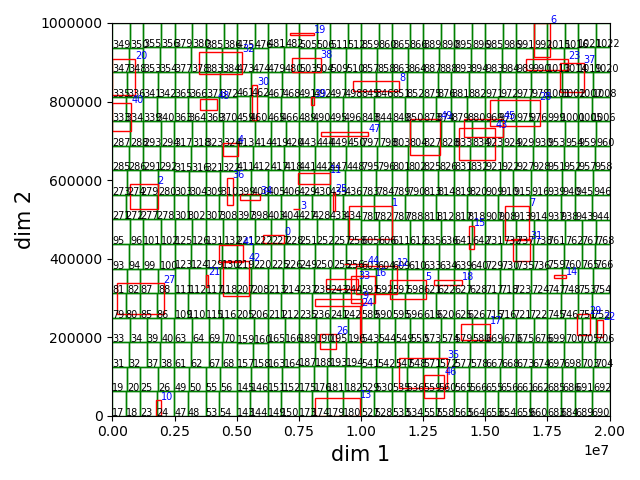

<IPython.core.display.Javascript object>


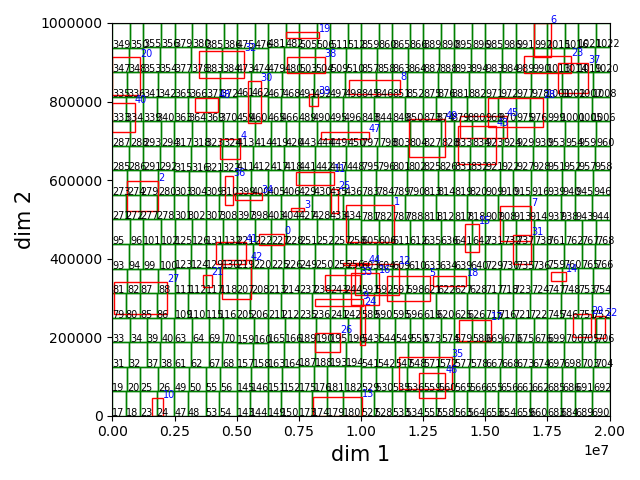

Total logical IOs: 2566971
Average logical IOs: 51339
query 0 [222, 227]
query 1 [258, 434, 605, 606, 611, 781, 782]
query 2 [272, 274, 277, 278, 279]
query 3 [404, 427]
query 4 [322, 323, 324, 411, 413]
query 5 [590, 592, 595, 596, 597, 598, 619, 621]
query 6 [990, 992, 1013, 1015]
query 7 [732, 737, 908, 913]
query 8 [498, 845, 846, 851]
query 9 [236, 241, 242, 589]
query 10 [23, 24]
query 11 [406, 429, 430, 435]
query 12 [242, 244, 256, 589, 590, 591, 592, 595, 597, 603, 604, 609]
query 13 [174, 179, 180]
query 14 [747, 748]
query 15 [639, 640, 641, 642]
query 16 [242, 244, 589, 590, 591]
query 17 [579, 580, 669]
query 18 [621, 622, 627]
query 19 [482, 505]
query 20 [335, 336, 347, 348]
query 21 [112, 117]
query 22 [706]
query 23 [989, 990, 1013, 1014]
query 24 [194, 196, 242, 543, 589]
query 25 [433, 435]
query 26 [188, 190, 193, 195]
query 27 [79, 80, 81, 82, 85, 86, 87, 88]
query 28 [923, 924, 929, 930, 969, 970, 975, 976]
query 29 [700, 705, 746, 751]
query 30 [460, 462]
query 3

3024100

In [224]:
pa1.partition_tree.visualize(queries = training_set)
pa1.partition_tree.visualize(queries = testing_set)
# pa1.partition_tree.visualize(queries = extended_training_set)
pa1.partition_tree.evaluate_query_cost(training_set)
pa1.partition_tree.evaluate_query_cost(testing_set)

### Test the logical IO of QdTree on both training set and testing set (with visualization)

In [225]:
# = = = = = Test PartitionAlgorithm (QDT) = = = = = 
pa2 = PartitionAlgorithm()
pa2.InitializeWithQDT(training_set, len(boundary)//2, boundary, dataset, data_threshold = 10000)

# number of leaf nodes: 1
 Split on node id: 0
# number of leaf nodes: 2
 Split on node id: 1
 Split on node id: 2
# number of leaf nodes: 4
 Split on node id: 3
 Split on node id: 4
 Split on node id: 5
 Split on node id: 6
# number of leaf nodes: 8
 Split on node id: 7
 Split on node id: 8
 Split on node id: 9
 Split on node id: 10
 Split on node id: 11
 Split on node id: 12
 Split on node id: 13
 Split on node id: 14
# number of leaf nodes: 16
 Split on node id: 15
 Split on node id: 16
 Split on node id: 17
 Split on node id: 18
 Split on node id: 19
 Split on node id: 20
 Split on node id: 21
 Split on node id: 22
 Split on node id: 23
 Split on node id: 24
 Split on node id: 25
 Split on node id: 26
 Split on node id: 27
 Split on node id: 28
 Split on node id: 29
 Split on node id: 30
# number of leaf nodes: 32
 Split on node id: 31
 Split on node id: 33
 Split on node id: 35
 Split on node id: 36
 Split on node id: 37
 Split on node id: 38
 Split on node id: 39
 Split on node i

<IPython.core.display.Javascript object>


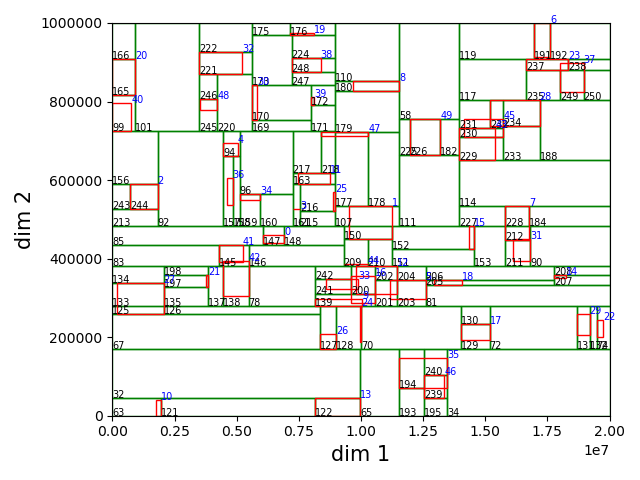

Total logical IOs: 1518827
Average logical IOs: 30376
query 0 [147]
query 1 [150, 107]
query 2 [244]
query 3 [161]
query 4 [94]
query 5 [201, 203]
query 6 [191]
query 7 [212, 228]
query 8 [180]
query 9 [139]
query 10 [63]
query 11 [163]
query 12 [200, 201, 202]
query 13 [122]
query 14 [207]
query 15 [152]
query 16 [139, 200]
query 17 [129]
query 18 [205]
query 19 [176]
query 20 [165]
query 21 [197]
query 22 [74]
query 23 [237]
query 24 [128]
query 25 [216]
query 26 [127]
query 27 [125, 133]
query 28 [232, 234]
query 29 [131]
query 30 [170]
query 31 [211, 212]
query 32 [221]
query 33 [241, 200]
query 34 [159]
query 35 [194, 239, 240]
query 36 [157]
query 37 [249, 237, 238]
query 38 [248]
query 39 [172]
query 40 [99]
query 41 [145]
query 42 [138, 145]
query 43 [229, 230]
query 44 [209]
query 45 [230, 231, 232]
query 46 [239]
query 47 [218, 177]
query 48 [245]
query 49 [226]


<IPython.core.display.Javascript object>


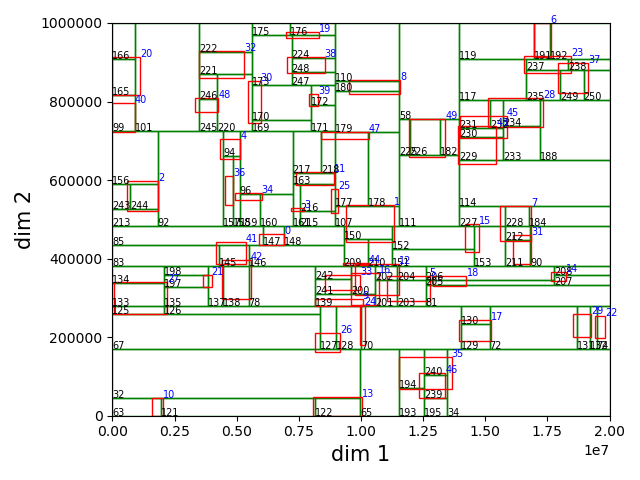

Total logical IOs: 11438860
Average logical IOs: 228777
query 0 [146, 85, 147, 148]
query 1 [209, 210, 150, 152, 107, 177, 178]
query 2 [213, 243, 244, 156, 92]
query 3 [160, 161, 216]
query 4 [92, 157, 158, 94, 96]
query 5 [201, 202, 203, 204, 81, 205, 206]
query 6 [119, 191, 192]
query 7 [153, 211, 212, 90, 227, 228, 184, 114]
query 8 [179, 180, 110, 58]
query 9 [126, 127, 128, 70, 78, 139]
query 10 [63, 121]
query 11 [161, 216, 163, 217, 218]
query 12 [139, 200, 201, 202, 203, 204, 209, 210, 151]
query 13 [121, 122, 32, 65]
query 14 [205, 206, 207, 208]
query 15 [151, 152, 153, 227]
query 16 [139, 241, 242, 200, 201, 202]
query 17 [70, 129, 130, 72]
query 18 [81, 205, 206]
query 19 [173, 224, 175, 176]
query 20 [99, 165, 166, 101]
query 21 [135, 197, 198, 137]
query 22 [132, 74]
query 23 [117, 235, 249, 237, 238, 119, 191, 192]
query 24 [128, 70, 139]
query 25 [215, 216, 107, 177]
query 26 [32, 67, 127, 128]
query 27 [67, 125, 126, 133, 134, 135, 197]
query 28 [231, 232, 233, 234, 1

11438860

In [226]:
pa2.partition_tree.visualize(queries = training_set)
pa2.partition_tree.evaluate_query_cost(training_set) # Average logical IOs: 196487
pa2.partition_tree.visualize(queries = testing_set)
pa2.partition_tree.evaluate_query_cost(testing_set) # Average logical IOs: 196487

### Test the logical IO of NORA on both training set and testing set (with visualization)

In [227]:
# = = = = = Test PartitionAlgorithm (NORA) = = = = = 
pa3 = PartitionAlgorithm()
pa3.InitializeWithNORA(extended_training_set, len(boundary)//2, boundary, dataset, data_threshold = 10000)

# number of leaf nodes: 1
current leaf node id: 0 leaf node dataset size: 6001309
 Split on node id: 0
# number of leaf nodes: 2
current leaf node id: 1 leaf node dataset size: 2967395
 Split on node id: 1
current leaf node id: 2 leaf node dataset size: 3033914
 Split on node id: 2
# number of leaf nodes: 4
current leaf node id: 3 leaf node dataset size: 1621178
 Split on node id: 3
current leaf node id: 4 leaf node dataset size: 1346217
 Split on node id: 4
current leaf node id: 5 leaf node dataset size: 1386974
 Split on node id: 5
current leaf node id: 6 leaf node dataset size: 1646940
 Split on node id: 6
# number of leaf nodes: 8
current leaf node id: 7 leaf node dataset size: 960181
 Split on node id: 7
current leaf node id: 8 leaf node dataset size: 660997
 Split on node id: 8
current leaf node id: 9 leaf node dataset size: 534328
 Split on node id: 9
current leaf node id: 10 leaf node dataset size: 811889
 Split on node id: 10
current leaf node id: 11 leaf node dataset size: 93

current leaf node id: 76 leaf node dataset size: 16521
current leaf node id: 79 leaf node dataset size: 107446
current leaf node id: 90 leaf node dataset size: 113326
current leaf node id: 92 leaf node dataset size: 185785
current leaf node id: 101 leaf node dataset size: 65716
current leaf node id: 106 leaf node dataset size: 148190
current leaf node id: 109 leaf node dataset size: 71826
current leaf node id: 112 leaf node dataset size: 182534
current leaf node id: 117 leaf node dataset size: 18673
current leaf node id: 118 leaf node dataset size: 18673
current leaf node id: 119 leaf node dataset size: 95181
current leaf node id: 120 leaf node dataset size: 36760
current leaf node id: 121 leaf node dataset size: 24763
current leaf node id: 122 leaf node dataset size: 89103
 Split on node id: 122
current leaf node id: 123 leaf node dataset size: 15706
current leaf node id: 124 leaf node dataset size: 37735
current leaf node id: 125 leaf node dataset size: 35904
 Split on node id: 125
c

current leaf node id: 173 leaf node dataset size: 66326
current leaf node id: 175 leaf node dataset size: 21408
current leaf node id: 176 leaf node dataset size: 32626
current leaf node id: 178 leaf node dataset size: 36032
current leaf node id: 180 leaf node dataset size: 13900
current leaf node id: 181 leaf node dataset size: 34631
current leaf node id: 182 leaf node dataset size: 35240
current leaf node id: 184 leaf node dataset size: 42399
current leaf node id: 185 leaf node dataset size: 49367
current leaf node id: 186 leaf node dataset size: 15939
current leaf node id: 187 leaf node dataset size: 34182
current leaf node id: 188 leaf node dataset size: 27347
current leaf node id: 190 leaf node dataset size: 44125
current leaf node id: 191 leaf node dataset size: 38012
current leaf node id: 194 leaf node dataset size: 137346
current leaf node id: 197 leaf node dataset size: 34210
current leaf node id: 198 leaf node dataset size: 55574
current leaf node id: 199 leaf node dataset siz

current leaf node id: 202 leaf node dataset size: 15894
current leaf node id: 203 leaf node dataset size: 21722
current leaf node id: 204 leaf node dataset size: 11919
current leaf node id: 205 leaf node dataset size: 10443
current leaf node id: 206 leaf node dataset size: 27553
current leaf node id: 207 leaf node dataset size: 52876
current leaf node id: 208 leaf node dataset size: 12599
current leaf node id: 209 leaf node dataset size: 11000
current leaf node id: 210 leaf node dataset size: 21312
current leaf node id: 211 leaf node dataset size: 28613
current leaf node id: 212 leaf node dataset size: 28613
current leaf node id: 213 leaf node dataset size: 16756
current leaf node id: 215 leaf node dataset size: 13900
current leaf node id: 217 leaf node dataset size: 17847
current leaf node id: 218 leaf node dataset size: 13657
current leaf node id: 219 leaf node dataset size: 11034
current leaf node id: 220 leaf node dataset size: 11037
current leaf node id: 221 leaf node dataset size

current leaf node id: 202 leaf node dataset size: 15894
current leaf node id: 203 leaf node dataset size: 21722
current leaf node id: 204 leaf node dataset size: 11919
current leaf node id: 205 leaf node dataset size: 10443
current leaf node id: 206 leaf node dataset size: 27553
current leaf node id: 207 leaf node dataset size: 52876
current leaf node id: 208 leaf node dataset size: 12599
current leaf node id: 209 leaf node dataset size: 11000
current leaf node id: 210 leaf node dataset size: 21312
current leaf node id: 211 leaf node dataset size: 28613
current leaf node id: 212 leaf node dataset size: 28613
current leaf node id: 213 leaf node dataset size: 16756
current leaf node id: 215 leaf node dataset size: 13900
current leaf node id: 217 leaf node dataset size: 17847
current leaf node id: 218 leaf node dataset size: 13657
current leaf node id: 219 leaf node dataset size: 11034
current leaf node id: 220 leaf node dataset size: 11037
current leaf node id: 221 leaf node dataset size

<IPython.core.display.Javascript object>


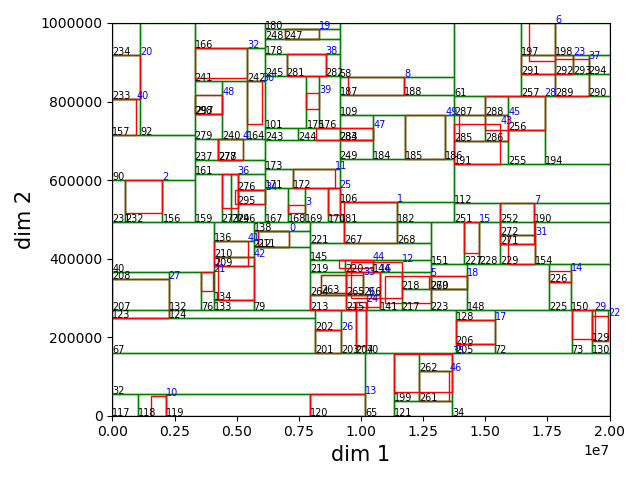

Total logical IOs: 1870565
Average logical IOs: 37411
query 0 [211]
query 1 [267, 181]
query 2 [232]
query 3 [168]
query 4 [277]
query 5 [141, 217, 218]
query 6 [291, 292, 197]
query 7 [271, 272, 252]
query 8 [187]
query 9 [213, 215]
query 10 [118]
query 11 [172]
query 12 [215, 265, 266, 141, 220, 144]
query 13 [120]
query 14 [226]
query 15 [227]
query 16 [215, 265, 266]
query 17 [206]
query 18 [218, 269, 270]
query 19 [247]
query 20 [233]
query 21 [76]
query 22 [129]
query 23 [291, 292]
query 24 [204, 215]
query 25 [170]
query 26 [201]
query 27 [123, 207]
query 28 [286, 288, 256]
query 29 [73, 129, 130]
query 30 [164]
query 31 [229, 271]
query 32 [241]
query 33 [263, 264, 265]
query 34 [274, 295, 296]
query 35 [199, 261, 262]
query 36 [273, 274]
query 37 [289, 292, 293]
query 38 [281]
query 39 [175]
query 40 [157]
query 41 [209, 210]
query 42 [134, 209]
query 43 [191, 285, 286]
query 44 [219, 220]
query 45 [285, 286]
query 46 [261]
query 47 [244, 283, 284]
query 48 [297]
query 49 [185

<IPython.core.display.Javascript object>


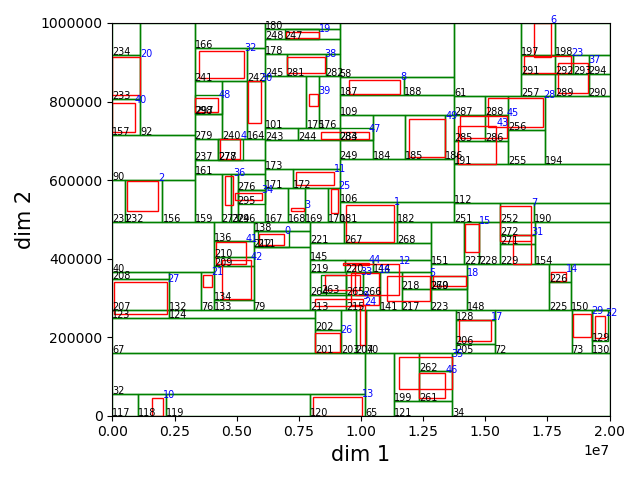

Total logical IOs: 1809207
Average logical IOs: 36184
query 0 [211]
query 1 [267, 181]
query 2 [232]
query 3 [168]
query 4 [277]
query 5 [141, 217, 218]
query 6 [291, 197]
query 7 [271, 272, 252]
query 8 [187]
query 9 [213, 215]
query 10 [118]
query 11 [172]
query 12 [215, 265, 266, 141, 220, 144]
query 13 [120]
query 14 [226]
query 15 [227]
query 16 [215, 265, 266]
query 17 [206]
query 18 [269]
query 19 [247]
query 20 [233]
query 21 [76]
query 22 [129]
query 23 [291, 292]
query 24 [204, 215]
query 25 [170]
query 26 [201]
query 27 [123, 207]
query 28 [286, 288, 256]
query 29 [73]
query 30 [164]
query 31 [229, 271]
query 32 [241]
query 33 [263, 264, 265]
query 34 [274, 295, 296]
query 35 [199, 261, 262]
query 36 [273, 274]
query 37 [289, 292, 293]
query 38 [281]
query 39 [175]
query 40 [157]
query 41 [209, 210]
query 42 [134, 209]
query 43 [191, 285, 286]
query 44 [219, 220]
query 45 [285, 286]
query 46 [261]
query 47 [244, 283, 284]
query 48 [297]
query 49 [185]


1809207

In [228]:
pa3.partition_tree.visualize(queries = extended_training_set)
pa3.partition_tree.evaluate_query_cost(extended_training_set)
pa3.partition_tree.visualize(queries = testing_set)
pa3.partition_tree.evaluate_query_cost(testing_set)

In [229]:
# pa3.partition_tree.nid_node_dict[32].if_split(1, 42566 ,10000, test=True)
# for nid, node in pa3.partition_tree.nid_node_dict.items():
#     if not node.is_leaf:
#         print("Internal:",nid, node.children_ids)
#     else:
#         print("Leaf:",nid, node.children_ids)